In [1]:
%matplotlib ipympl

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import patches 
from matplotlib import colors 
from matplotlib import cm
from scipy import spatial as spat

from scipy.spatial.distance import cdist
from itertools import cycle

In [3]:
def build_honeycomb(n,m, pitch):
    a_1 = np.array([3*pitch/2, np.sqrt(3)*pitch/2])
    a_2 = np.array([3*pitch/2, -np.sqrt(3)*pitch/2])

    coord_list = []
    for j in range(m):
        for i in range(n): 
            coord_list.append(a_1*i + a_2*j)

    coord_list_shifted = coord_list + np.array([-pitch, 0])
    coord_list = np.array(coord_list)
    # print(coord_list_shifted)


    full_coord_list = np.concatenate((coord_list, coord_list_shifted), axis=0)
    centered_coord_list = full_coord_list - (n*a_1 + m*a_2)/2 + np.array([2*pitch,0])

    return centered_coord_list

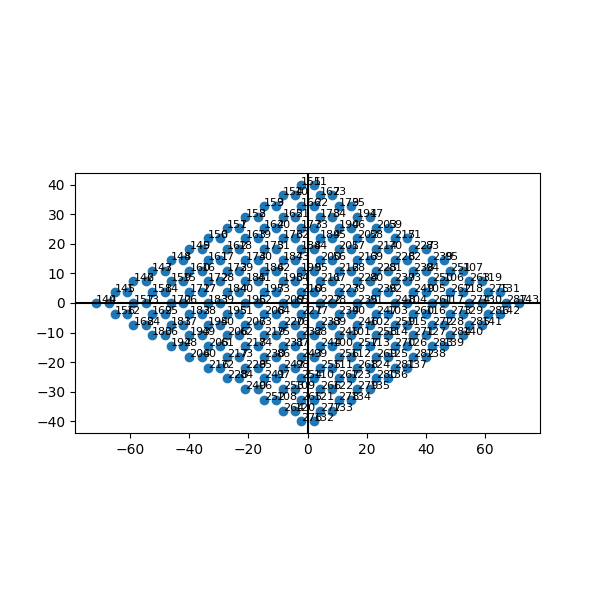

In [4]:

point_list = build_honeycomb(12, 12, 4.2)
fig_plot = plt.figure(figsize=(6,6))
ax_plot = fig_plot.add_subplot(111)
ax_plot.axhline(0, color='black')
ax_plot.axvline(0, color='black')
ax_plot.scatter(point_list[:,0], point_list[:,1])
ax_plot.set_aspect('equal')
for i in range(len(point_list)):
     ax_plot.annotate(str(i), (point_list[i,0], point_list[i,1]), fontsize=8)

plt.show()

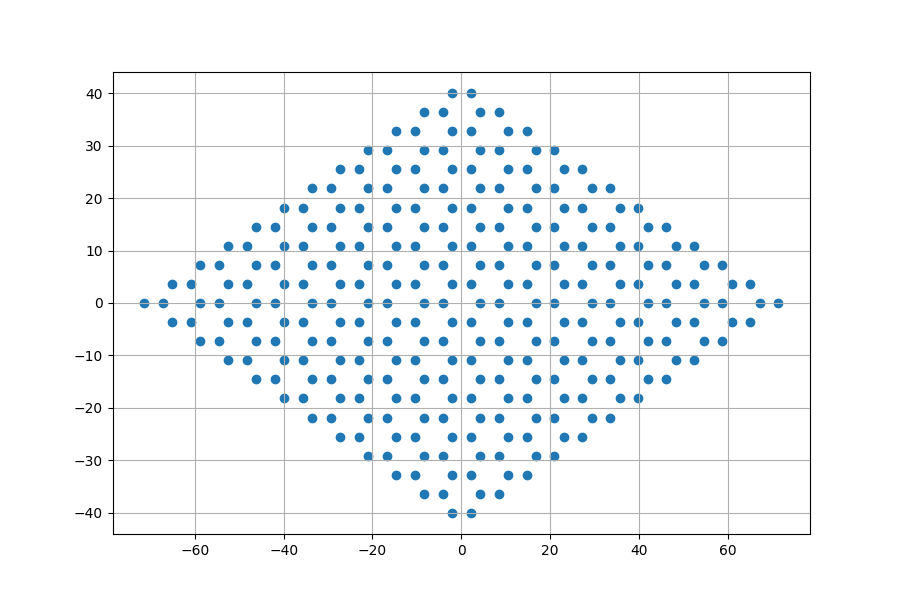

In [5]:
def onclick(event):
    pos.append([event.xdata,event.ydata])

pos = []

fig1 = plt.figure(figsize=(9,6))
ax1 = fig1.add_subplot(111)

ax1.scatter(point_list[:,0], point_list[:,1], cmap='Reds')
# ax1.xaxis.set_major_locator(MultipleLocator(10))
# ax1.xaxis.set_minor_locator(MultipleLocator(5))
# ax1.yaxis.set_major_locator(MultipleLocator(10))
# ax1.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.xaxis.set_major_formatter({x:.0f})
plt.grid(which='both')

fig1.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [6]:
pos = np.array(pos)
points_to_keep = np.where(cdist(point_list, pos, 'euclidean')>2, False, True )
index_to_keep = np.invert(np.any(points_to_keep, axis=1))
deformed_lattice= point_list[index_to_keep]


In [6]:
points_to_keep = np.where (cdist(point_list, np.array([[0,0]]), 'euclidean')<40, False, True)
index_to_keep = np.invert(np.any(points_to_keep, axis=1))
deformed_lattice = point_list[index_to_keep]

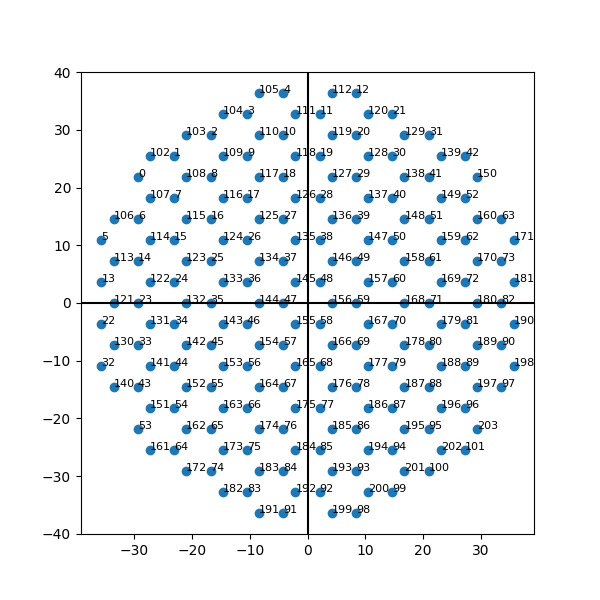

In [7]:

fig_deformed_lattice_plot = plt.figure(figsize=(6,6))
ax_deformed_lattice_plot = fig_deformed_lattice_plot.add_subplot(111)
ax_deformed_lattice_plot.axhline(0, color='black')
ax_deformed_lattice_plot.axvline(0, color='black')
ax_deformed_lattice_plot.scatter(deformed_lattice[:,0], deformed_lattice[:,1])
ax_deformed_lattice_plot.set_aspect('equal')
for i in range(len(deformed_lattice)):
    # print(i, coord)
    ax_deformed_lattice_plot.annotate(str(i), (deformed_lattice[i,0], deformed_lattice[i,1]), fontsize=8)
# print(len(b_10_list))

plt.show()

In [9]:

def vec_potential(x,y, twist_rate, beta):
    vec_A = twist_rate*beta*np.array([y,-x])
    return vec_A
    
def twisted_beta(beta_straight, twist_rate, radial_dist):
    beta_hel = beta_straight*np.sqrt(1+ twist_rate**2 * radial_dist**2)
    # print('Difference due to twist: {:.2f}'.format(beta_hel-beta_straight))
    return beta_hel

vec_twist_beta = np.vectorize(twisted_beta)

def build_onsite(beta_straight, twist, coord_pairs):
    distance_to_each_core = np.array([round(np.sqrt(i**2 + j**2),4) for i,j in coord_pairs])*1e-6

    twist_for_each_core = vec_twist_beta(beta_straight, twist, distance_to_each_core) - beta_straight
    onsite_matrix = np.diag(twist_for_each_core)

    return onsite_matrix

def find_c(pair_list, pitch, coupling_c, beta_straight, twist, with_onsite=True, return_eigvals=False):
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=complex)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=100)
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.001, output_type = 'ndarray')

    for i in nearest_neighbour_array:
        mid_point = (pair_list[i[0]] + pair_list[i[1]])/2
        a_dist = (pair_list[i[0]] - pair_list[i[1]])*1.0e-6
        # print(mid_point)
        vec_term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, twist, beta_straight)

        coupling_matrix[i[0],i[1]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist))

        a_dist_rev = (pair_list[i[1]] - pair_list[i[0]])*1.0e-6
        coupling_matrix[i[1],i[0]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist_rev))
    if with_onsite is True:
        onsite_matrix = build_onsite(beta_straight, twist, pair_list)
        full_C = coupling_matrix + onsite_matrix
    else: 
        full_C = coupling_matrix
    # print(np.allclose(full_C, np.transpose(np.conjugate(full_C))))

    if return_eigvals is True:
        beta_super, eigvecs = np.linalg.eigh(full_C)
        return beta_super,eigvecs
    else:
        return full_C

def find_c_haldane(pair_list, pitch, coupling_c1, coupling_c2, M, beta_0, return_eigvals=False):
    """  
        pair_list is the lattice coord list, pitch is the distance between nearest neighbours,
        coupling_c1 is nn coupling, coupling_c2 is nnn coupling, M is the onsite term.

        First I build a tree and find all nearest and next-nearest neighbours, splitting them 
        into separate lists to build up the coupling matrix with. 

        The angle between points (when nnn) is calculated to determine the sign of the imaginary 
        coupling. This gives the points a positive imaginary coupling if they're travelling 
        anticlockwise and negative if clockwise.
    """
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=np.complex128)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=50)
    next_and_neighbour_array = honeycomb_point_tree.query_pairs(np.sqrt(3)*(pitch+0.001), output_type = 'ndarray')
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.0001, output_type = 'ndarray')
    
    # easiest to create a list of tuples to remove any nearest neighbours from all pairs
    #  within next-nearest neighbour distance
    tup_all_list = [(i[0],i[1]) for i in next_and_neighbour_array]
    tup_nn_list = [(i[0],i[1]) for i in nearest_neighbour_array]
    tup_next_n_list = [i for i in tup_all_list if i not in tup_nn_list]

    for n in nearest_neighbour_array:
        coupling_matrix[n[0],n[1]] = coupling_c1
        coupling_matrix[n[1],n[0]] = coupling_c1

    # Logic to build up clockwise dependent phase in next-nearest neighbour coupling
    for i in tup_next_n_list:
        if i[0] >= len(pair_list)//2:
            a_or_b = -1
        else:
            a_or_b = 1
        # print(a_or_b)
        vec_between_points = pair_list[i[1]] - pair_list[i[0]]
        if vec_between_points[0] == 0:
            if vec_between_points[1] > 0:
                coupling_i = 1.0j*coupling_c2  
            elif vec_between_points[1] < 0: 
                coupling_i = -1.0j*coupling_c2 
        else:
            angle_between_points = np.arctan(vec_between_points[1]/vec_between_points[0])
            if angle_between_points > 0 and angle_between_points < 4*np.pi/10:
                coupling_i = -1.0j*coupling_c2 
            elif angle_between_points < 0 and angle_between_points > -4*np.pi/10: 
                coupling_i = 1.0j*coupling_c2 

        coupling_matrix[i[0],i[1]] = a_or_b*coupling_i
        coupling_matrix[i[1],i[0]] = -a_or_b*coupling_i       
    a_size = int(len(pair_list[:,0])/2)
    onsite = np.block([[np.eye(a_size),np.zeros((a_size, a_size))],
                       [np.zeros((a_size, a_size)),np.eye(a_size)*-1]])*M #np.eye(len(pair_list[:,0]),dtype=np.complex128)*M 
    # add_betas = np.eye(len(pair_list[:,0]),dtype=np.complex128)*beta_0
    # print(add_betas)
    full_matrix = coupling_matrix #+ onsite #+ add_betas
    # display(pd.DataFrame(full_matrix))
    if return_eigvals is True:
        beta_super, eigvecs = np.linalg.eigh(full_matrix)
        return beta_super, eigvecs
    else:
        return full_matrix



In [110]:
C_MATRIX = find_c(deformed_lattice, 4.2, 6700.0, 5876619.5, 2000.0, with_onsite=False)
# C_MATRIX = find_c_haldane(deformed_lattice, 4.2, 1.0, 0.0, 0.0, 0.0)
INIT_EXCITATION = np.zeros(np.shape(C_MATRIX)[0], dtype=np.complex128)

INIT_EXCITATION[31] = 1
# INIT_EXCITATION[0] = 1


DELTA_Z = 0.000001

In [111]:
def loop_FD(coupling_matrix, number_of_steps, initial_state, step_size):
    phis = np.zeros((np.shape(coupling_matrix)[0], number_of_steps), dtype=np.complex128)
    phis[:,0] = initial_state
    for i in np.arange(1,number_of_steps):
        phis[:,i] = phis[:,i-1] - 1.0j * coupling_matrix@phis[:,i-1] * step_size
    return phis

In [112]:
phi_mat = loop_FD(C_MATRIX, 2000, INIT_EXCITATION, DELTA_Z)
intensity_to_plot = phi_mat*np.conjugate(phi_mat) / np.sum(phi_mat*np.conjugate(phi_mat), axis=0)
print(np.shape(intensity_to_plot))
print(intensity_to_plot[37,-1], intensity_to_plot[31,-1])

(204, 2000)
(0.00014080699139972872+0j) (0.0045198326353561085+0j)


In [113]:
def make_video(coord_list, intensities, fname, frame_no):
    fig = plt.figure()
    fig.set_dpi(400)
    fig.set_size_inches(10, 10)

    radius = 2.0
    x_y_max = np.max(coord_list, axis=0)+radius*2
    ax = plt.axes(xlim=(-x_y_max[0], x_y_max[0]), ylim=(-x_y_max[0], +x_y_max[0]))

    patch_list = []
    for j in range(len(coord_list)):
        patch_list.append(patches.Circle((coord_list[j][0], coord_list[j][1]), radius=radius)) 

    def init():
        for j in range(len(patch_list)):
            patch_list[j].center = (coord_list[j][0], coord_list[j][1])
            patch_list[j].set_edgecolor('black')
            patch_list[j].set_facecolor('White')
            ax.add_patch(patch_list[j])
        return patch_list,

    def animate(i):
        norm = colors.Normalize(vmin=0, vmax=np.max(np.real(intensities[:,i])))
        cmap = plt.cm.get_cmap('Reds')
        for j in range(len(patch_list)):
            patch_list[j].set_edgecolor('black')
            patch_list[j].set_facecolor(cmap(norm(np.real(intensities[j,i]))))
        return patch_list,

    anim = animation.FuncAnimation(fig, animate, 
                                init_func=init, 
                                frames=frame_no, 
                                interval=1,
                                blit=False,
                                save_count=frame_no,
                                repeat=True)
    writervideo = animation.FFMpegWriter(fps=60)
    
    plt.axis('off')
    anim.save('../Propagation Videos/'+fname, writer=writervideo)
    
    plt.close()
# plt.show()
    return 

In [114]:
make_video(deformed_lattice, intensity_to_plot, 'twisted fibre propagation no onsite.mp4', 2000)
# plt.show()

In [30]:
two_core = np.array([[0,100],[100,0]])
two_core_phi_mat = loop_FD(two_core, 1000, np.array([1,0]), 0.0001)

intensity_two_core = two_core_phi_mat*np.conjugate(two_core_phi_mat) / np.sum(two_core_phi_mat*np.conjugate(two_core_phi_mat), axis=0)

In [31]:
make_video(np.array([[-3,0],[3,0]]), intensity_two_core, 'two core propagation.mp4', 1000)

In [28]:
def plot_chain(circ_size, circ_locations):
    """
    
    """
    fig_chain = plt.figure(figsize=(5,5))
    ax_chain = fig_chain.add_subplot(111)
    circ_list = []

    for j in range(len(circ_locations)):
        circ_list.append(patches.Circle((circ_locations[j][0], circ_locations[j][1]), radius=circ_size//2,
                                            color='white',ec='black')) 
   
    plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)
    plt.axis('scaled')
    fig_chain.savefig('../Propagation Videos/honeycomb fibre.png')
    plt.show()     
    return  

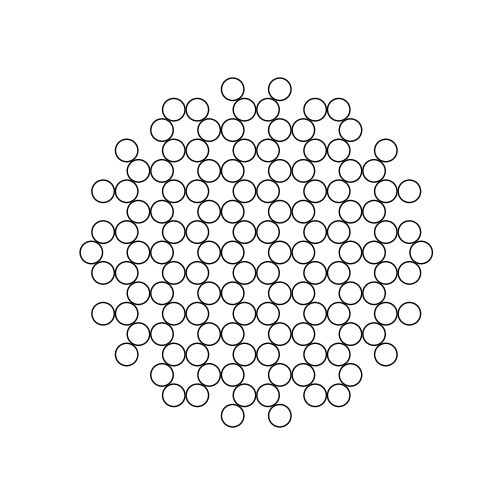

In [29]:
plot_chain(4,deformed_lattice)

In [34]:
twisted_betas, twisted_vecs = find_c(deformed_lattice, 4.2, 6700.0, 5876619.5, 800.0, with_onsite=False, return_eigvals=True)
twisted_betas_onsite, twisted_vecs_onsite = find_c(deformed_lattice, 4.2, 6700.0, 5876619.5, 800.0, with_onsite=True, return_eigvals=True)
haldane_betas, haldane_vecs = find_c_haldane(deformed_lattice, 4.2, 1.0, 0.2, 0.0, 0.0, return_eigvals=True )

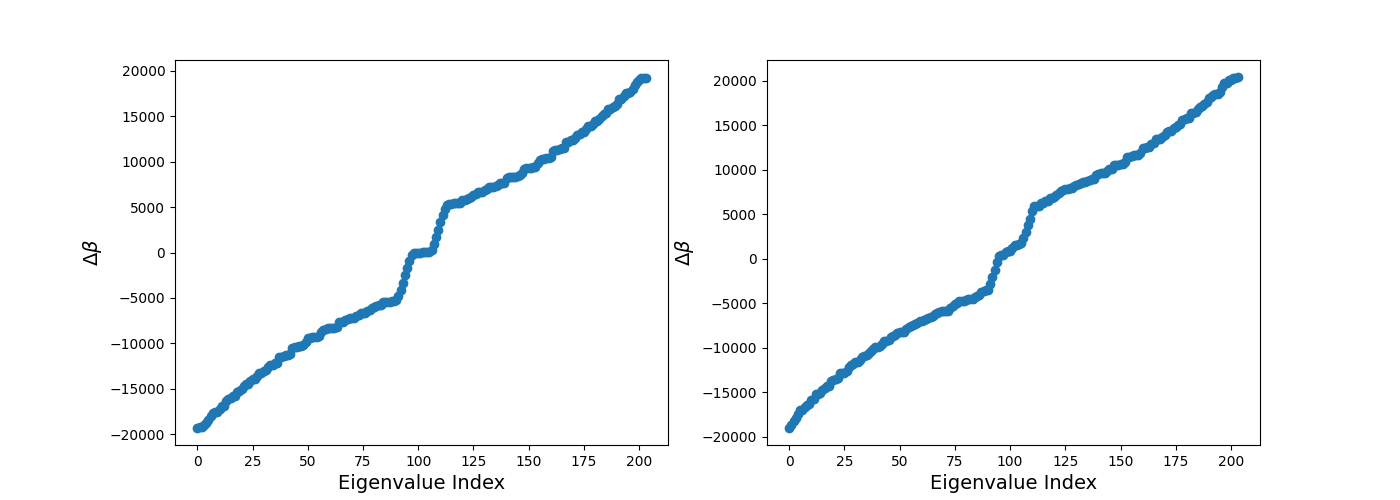

In [35]:
fig_eigvals = plt.figure(figsize=(14, 5))
ax_eigvals = fig_eigvals.add_subplot(121)
ax_eigvals_haldane = fig_eigvals.add_subplot(122)
ax_eigvals.scatter(np.arange(len(twisted_betas)), twisted_betas)
ax_eigvals.set_xlabel('Eigenvalue Index', fontsize=14)
ax_eigvals.set_ylabel(r'$\Delta \beta$', fontsize=14)
ax_eigvals_haldane.set_ylabel(r'$\Delta \beta$', fontsize=14)
ax_eigvals_haldane.set_xlabel('Eigenvalue Index', fontsize=14)
ax_eigvals_haldane.scatter(np.arange(len(haldane_betas)), twisted_betas_onsite)

fig_eigvals.savefig('../Twisted Fibre/Figures/different band gaps onsite.png', dpi=300)

plt.show()